# Unit03｜化工場資料型態（Batch / Continuous）

對應講義：`Part_1/Unit03_ChemEng_Data_Types.md`

In [1]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
# Part_1 課程結果儲存在 Part_1 資料夾內
PART1_DIR = REPO_ROOT / 'Part_1'
OUTPUT_DIR = PART1_DIR / 'Unit03_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(PART1_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('PART1_DIR:', PART1_DIR)
print('Working dir:', os.getcwd())
print('Results will be saved to:', OUTPUT_DIR)

REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
PART1_DIR: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1
Results will be saved to: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1\Unit03_Results


## 1) Continuous：多變量時間序列（time, feature）

重點：時間軸是全廠共用的（或至少是一條連續時間線），常見操作是：`to_datetime`、對時、補值、重採樣、rolling/diff。

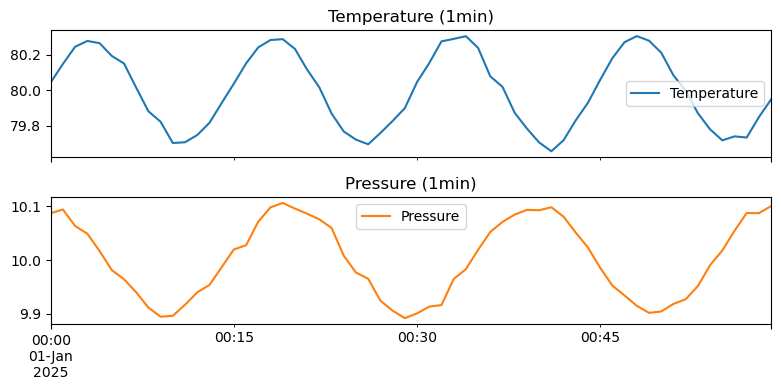

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = pd.date_range('2025-01-01', periods=6*60, freq='10s')  # 10 秒一筆，共 60 分鐘
df_cont = pd.DataFrame(
    {
        'Temperature': 80 + 0.3*np.sin(np.linspace(0, 8*np.pi, len(rng))) + np.random.normal(0, 0.05, len(rng)),
        'Pressure': 10 + 0.1*np.cos(np.linspace(0, 6*np.pi, len(rng))) + np.random.normal(0, 0.02, len(rng)),
    },
    index=rng,
)

# 重採樣成 1 分鐘一筆
df_1min = df_cont.resample('1min').mean()

ax = df_1min.plot(subplots=True, figsize=(8, 4), title=['Temperature (1min)', 'Pressure (1min)'])
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '01_continuous_resample.png', dpi=140, bbox_inches='tight')
plt.show()

## 2) Batch：多批次 × 多時間 × 多變數

重點：每一批有自己的開始/結束，且批次長度可能不同。

下面先用 long format（每列是一個時間點）示意，再說明什麼時候會轉成 `(batch, time, feature)`。

In [3]:
np.random.seed(0)

batches = []
for batch_id, n_points in [(1, 80), (2, 120), (3, 95)]:
    t = np.arange(n_points)
    temp = 75 + 0.08*t + np.random.normal(0, 0.4, n_points)
    pressure = 9 + 0.02*t + np.random.normal(0, 0.15, n_points)
    phase = np.where(t < n_points*0.2, 'heat-up', np.where(t < n_points*0.8, 'reaction', 'cool-down'))
    batches.append(
        pd.DataFrame(
            {
                'BatchID': batch_id,
                't_min': t,
                'Phase': phase,
                'Temperature': temp,
                'Pressure': pressure,
            }
        )
    )

df_batch_long = pd.concat(batches, ignore_index=True)
print('Batch Data Structure (long format):')
display(df_batch_long.head())

# 批次彙整特徵（Batch-level）
df_batch_summary = df_batch_long.groupby('BatchID').agg(
    temp_mean=('Temperature', 'mean'),
    temp_std=('Temperature', 'std'),
    pressure_mean=('Pressure', 'mean'),
    n_points=('t_min', 'count'),
).reset_index()
print('\nBatch Summary (Aggregated):')
display(df_batch_summary)

print('\n[範例] Batch 1 的 reaction phase 資料片段:')
display(
    df_batch_long[(df_batch_long['BatchID']==1) & (df_batch_long['Phase']=='reaction')].head()
)

Batch Data Structure (long format):


,BatchID,t_min,Phase,Temperature,Pressure
0,1,0,heat-up,75.705621,8.825228
1,1,1,heat-up,75.240063,9.155124
2,1,2,heat-up,75.551495,9.109849
3,1,3,heat-up,76.136357,8.829563
4,1,4,heat-up,76.067023,9.303238



Batch Summary (Aggregated):


,BatchID,temp_mean,temp_std,pressure_mean,n_points
0,1,78.147783,1.763034,9.825671,80
1,2,79.710281,2.784765,10.173643,120
2,3,78.764573,2.276804,9.906447,95



[範例] Batch 1 的 reaction phase 資料片段:


,BatchID,t_min,Phase,Temperature,Pressure
16,1,16,reaction,76.877632,9.321575
17,1,17,reaction,76.277937,9.607881
18,1,18,reaction,76.565227,9.379037
19,1,19,reaction,76.178362,9.440298
20,1,20,reaction,75.578804,9.682473


## 3)（原 Unit01 延伸案例）批次「最終品質」資料 EDA

以下內容原本放在 Unit01 最後；在新版結構中移到 Unit03，專注在批次資料語意與快速品質探索。

[批次資料前 5 筆]


,BatchID,React_Temp,Agitator_Speed,React_Time,Mn_kDa,Temp_dev,Time_dev,Efficiency_idx
0,1,83.528105,303.098949,116.637698,51.881488,3.528105,-3.362302,0.444809
1,2,80.800314,307.563250,118.202234,52.294143,0.800314,-1.797766,0.442412
2,3,81.957476,282.244285,115.934269,51.471820,1.957476,-4.065731,0.443974
3,4,84.481786,260.384071,111.368587,54.187246,4.481786,-8.631413,0.486558
4,5,83.735116,293.041757,120.887131,53.611355,3.735116,0.887131,0.443483


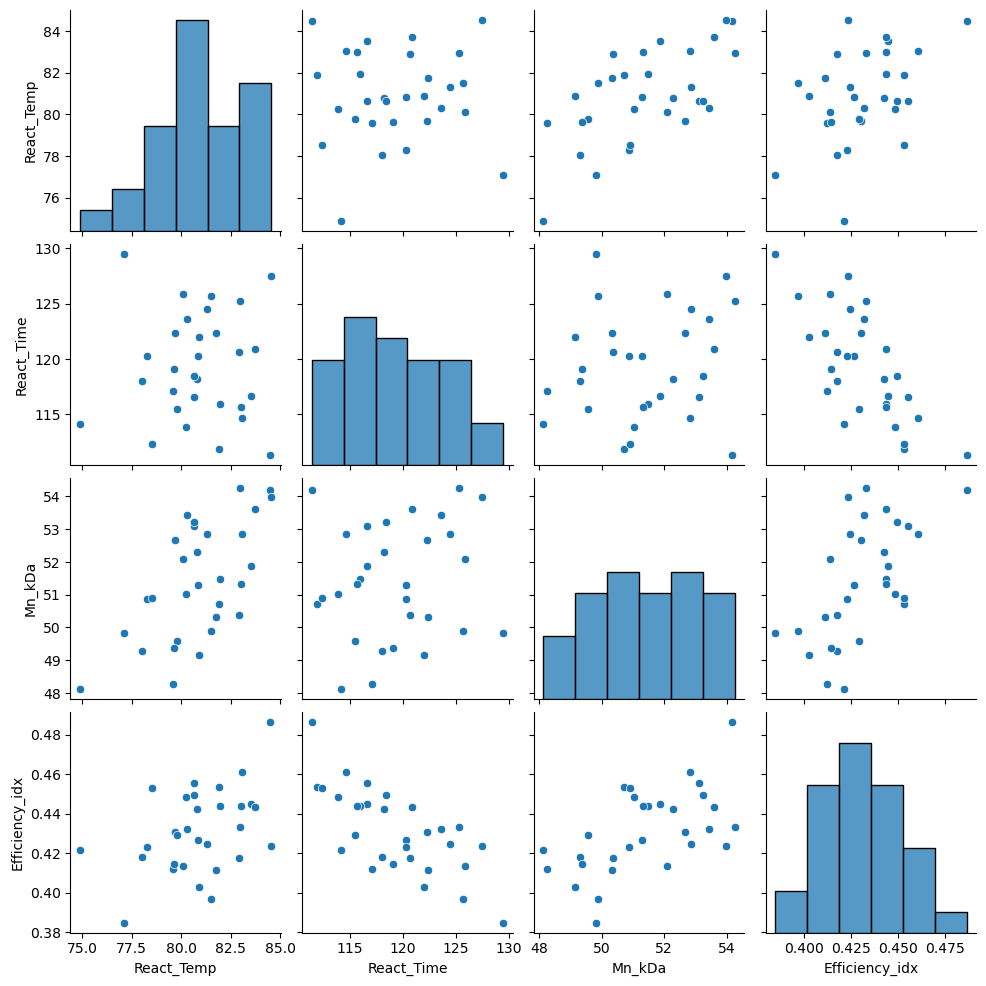

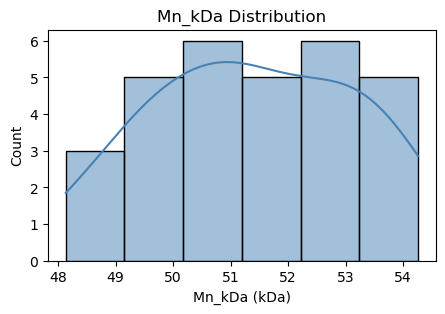

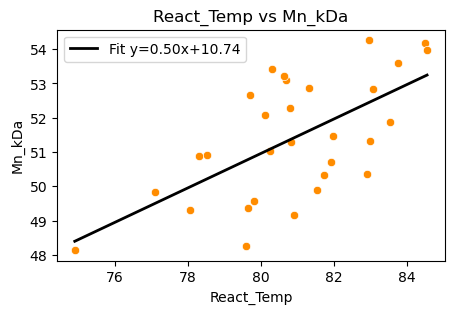

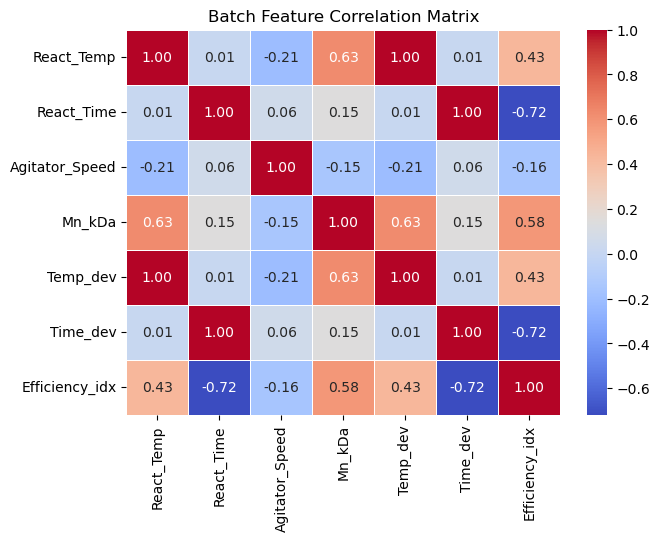

[線性迴歸係數 (標準化後)] React_Temp, React_Time: [1.08514237 0.24133447] 截距: 51.40795990076211


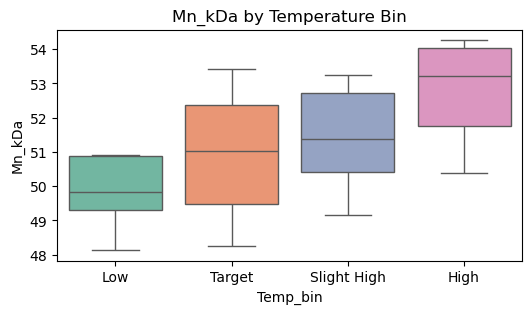

[溫度分箱 Mn_kDa 統計]


,count,mean,std
Temp_bin,,,
Low,5,49.809152,1.165429
Target,7,50.916192,1.912057
Slight High,10,51.432178,1.420689
High,8,52.807238,1.463587


[Done] Figures saved to Unit03_Results/


In [4]:
# Batch-level EDA (moved from Unit01)
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings

np.random.seed(0)
n_batches = 30
df_batch = pd.DataFrame({
    'BatchID': np.arange(1, n_batches + 1),
    'React_Temp': np.random.normal(loc=80, scale=2, size=n_batches),
    'Agitator_Speed': np.random.normal(loc=300, scale=20, size=n_batches),
    'React_Time': np.random.normal(loc=120, scale=5, size=n_batches),
})

# 生成品質 Mn_kDa：線性關係 + 噪音
df_batch['Mn_kDa'] = (
    50
    + 0.8 * (df_batch['React_Temp'] - 80)
    + 0.1 * (df_batch['React_Time'] - 120)
    + np.random.normal(0, 1.5, n_batches)
)

# 特徵工程：偏差與簡易效率指標
df_batch['Temp_dev'] = df_batch['React_Temp'] - 80
df_batch['Time_dev'] = df_batch['React_Time'] - 120
df_batch['Efficiency_idx'] = df_batch['Mn_kDa'] / df_batch['React_Time']

print('[批次資料前 5 筆]')
display(df_batch.head())

# 1. Pairplot
sns.pairplot(df_batch[['React_Temp','React_Time','Mn_kDa','Efficiency_idx']])
plt.savefig('Unit03_Results/06_batch_pairplot.png', dpi=120, bbox_inches='tight')
plt.show()

# 2. Mn 分佈
plt.figure(figsize=(5,3))
sns.histplot(df_batch['Mn_kDa'], kde=True, color='steelblue')
plt.title('Mn_kDa Distribution')
plt.xlabel('Mn_kDa (kDa)')
plt.ylabel('Count')
plt.savefig('Unit03_Results/07_batch_mn_hist.png', dpi=120, bbox_inches='tight')
plt.show()

# 3. 溫度 vs Mn 散佈 + 回歸線
plt.figure(figsize=(5,3))
sns.scatterplot(x='React_Temp', y='Mn_kDa', data=df_batch, color='darkorange')

with warnings.catch_warnings():
    try:
        warnings.simplefilter('ignore', category=np.RankWarning)
    except AttributeError:
        pass
    coef = np.polyfit(df_batch['React_Temp'], df_batch['Mn_kDa'], 1)

xline = np.linspace(df_batch['React_Temp'].min(), df_batch['React_Temp'].max(), 50)
plt.plot(xline, coef[0]*xline + coef[1], color='black', linewidth=2, label=f'Fit y={coef[0]:.2f}x+{coef[1]:.2f}')
plt.legend()
plt.title('React_Temp vs Mn_kDa')
plt.savefig('Unit03_Results/08_batch_temp_vs_mn.png', dpi=120, bbox_inches='tight')
plt.show()

# 4. 相關係數熱圖
corr = df_batch[['React_Temp','React_Time','Agitator_Speed','Mn_kDa','Temp_dev','Time_dev','Efficiency_idx']].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Batch Feature Correlation Matrix')
plt.savefig('Unit03_Results/09_batch_corr.png', dpi=120, bbox_inches='tight')
plt.show()

X = df_batch[['React_Temp','React_Time']]
y = df_batch['Mn_kDa']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr = LinearRegression().fit(X_scaled, y)
print('[線性迴歸係數 (標準化後)] React_Temp, React_Time:', lr.coef_, '截距:', lr.intercept_)

bins = [df_batch['React_Temp'].min()-1, 79, 80.5, 82, df_batch['React_Temp'].max()+1]
labels = ['Low','Target','Slight High','High']
df_batch['Temp_bin'] = pd.cut(df_batch['React_Temp'], bins=bins, labels=labels)

plt.figure(figsize=(6,3))
sns.boxplot(x='Temp_bin', y='Mn_kDa', data=df_batch, palette='Set2', hue='Temp_bin', legend=False)
plt.title('Mn_kDa by Temperature Bin')
plt.savefig('Unit03_Results/10_batch_box_by_temp_bin.png', dpi=120, bbox_inches='tight')
plt.show()

summary = df_batch.groupby('Temp_bin', observed=False)['Mn_kDa'].agg(['count','mean','std'])
print('[溫度分箱 Mn_kDa 統計]')
display(summary)
print('[Done] Figures saved to Unit03_Results/')

## 🚀 進階案例：非線性效應與交互作用分析

在實際化工製程中，操作變數對品質的影響常呈現非線性與交互作用。
讓我們用剛才產生的批次數據進行更深入的分析。

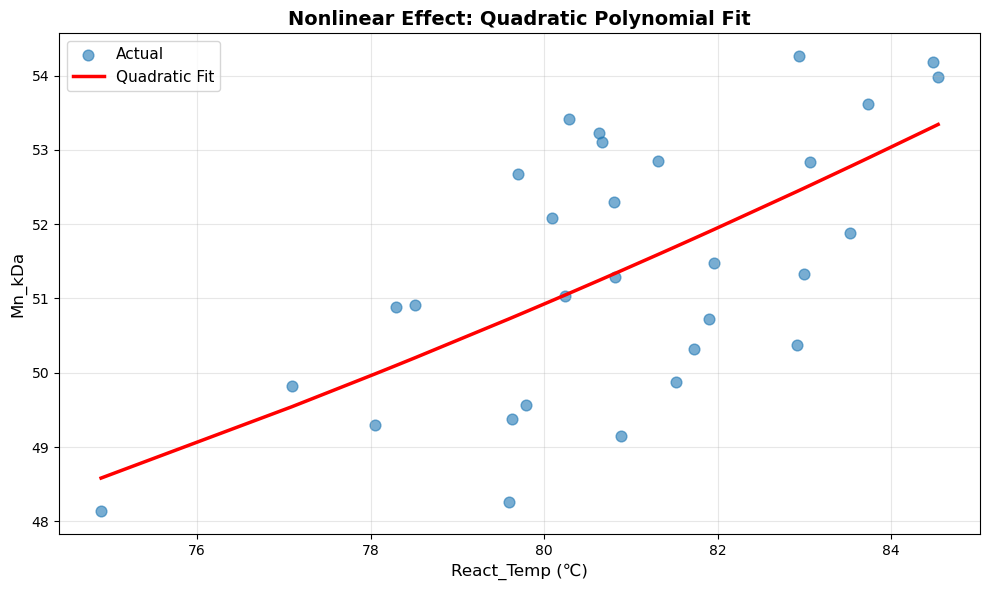

線性 R² vs 二次多項式 R²:
線性模型 R² (僅 React_Temp): 0.392
二次模型 R²: 0.392


In [5]:
# 1. 非線性效應：二次多項式擬合
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# 建立二次特徵
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_batch[['React_Temp']])
y = df_batch['Mn_kDa']

# 擬合
model_poly = LinearRegression().fit(X_poly, y)
df_batch['Mn_pred_poly'] = model_poly.predict(X_poly)

# 視覺化
plt.figure(figsize=(10, 6))
plt.scatter(df_batch['React_Temp'], df_batch['Mn_kDa'], alpha=0.6, label='Actual', s=60)
plt.plot(df_batch['React_Temp'].sort_values(), 
         df_batch.sort_values('React_Temp')['Mn_pred_poly'], 
         color='red', label='Quadratic Fit', linewidth=2.5)
plt.xlabel('React_Temp (℃)', fontsize=12)
plt.ylabel('Mn_kDa', fontsize=12)
plt.legend(fontsize=11)
plt.title('Nonlinear Effect: Quadratic Polynomial Fit', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '11_batch_nonlinear.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"線性 R² vs 二次多項式 R²:")

# 線性模型（僅 React_Temp）以便與二次多項式比較
lr_temp = LinearRegression().fit(df_batch[['React_Temp']], y)
linear_r2 = r2_score(y, lr_temp.predict(df_batch[['React_Temp']]))

print(f"線性模型 R² (僅 React_Temp): {linear_r2:.3f}")
print(f"二次模型 R²: {r2_score(y, df_batch['Mn_pred_poly']):.3f}")

交互作用模型係數：
  Temp: -0.2454
  Agitator: -0.2100
  Temp×Agit: 0.0026
截距: 71.8171
R²: 0.394


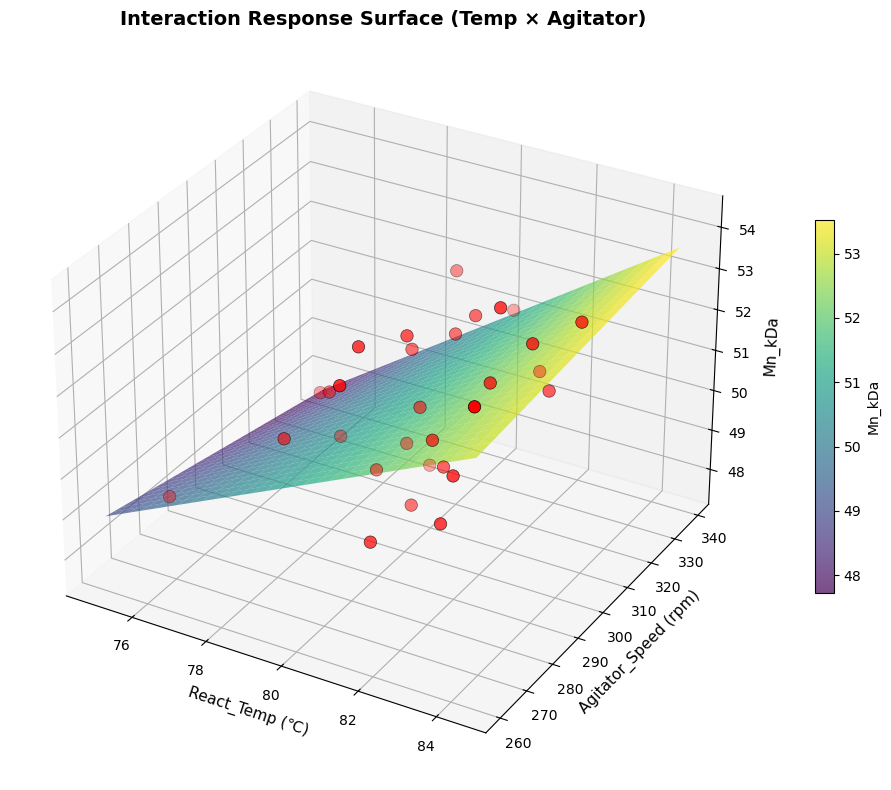

In [6]:
# 2. 交互作用：溫度 × 攪拌速度（3D 響應曲面）
from mpl_toolkits.mplot3d import Axes3D

# 建立交互項
df_batch['Temp_x_Agit'] = df_batch['React_Temp'] * df_batch['Agitator_Speed']

# 線性回歸（含交互項）
X_interact = df_batch[['React_Temp', 'Agitator_Speed', 'Temp_x_Agit']]
model_interact = LinearRegression().fit(X_interact, y)

print("交互作用模型係數：")
for name, coef in zip(['Temp', 'Agitator', 'Temp×Agit'], model_interact.coef_):
    print(f"  {name}: {coef:.4f}")
print(f"截距: {model_interact.intercept_:.4f}")
print(f"R²: {model_interact.score(X_interact, y):.3f}")

# 建立網格
temp_range = np.linspace(df_batch['React_Temp'].min(), df_batch['React_Temp'].max(), 30)
agit_range = np.linspace(df_batch['Agitator_Speed'].min(), df_batch['Agitator_Speed'].max(), 30)
T_grid, A_grid = np.meshgrid(temp_range, agit_range)

# 預測網格上的 Mn
Mn_grid = (model_interact.intercept_ + 
           model_interact.coef_[0] * T_grid + 
           model_interact.coef_[1] * A_grid + 
           model_interact.coef_[2] * T_grid * A_grid)

# 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_grid, A_grid, Mn_grid, cmap='viridis', alpha=0.7, edgecolor='none')
ax.scatter(df_batch['React_Temp'], df_batch['Agitator_Speed'], df_batch['Mn_kDa'], 
           color='red', s=80, label='Batch', edgecolors='black', linewidths=0.5)

ax.set_xlabel('React_Temp (℃)', fontsize=11)
ax.set_ylabel('Agitator_Speed (rpm)', fontsize=11)
ax.set_zlabel('Mn_kDa', fontsize=11)
ax.set_title('Interaction Response Surface (Temp × Agitator)', fontsize=14, fontweight='bold')
fig.colorbar(surf, shrink=0.5, label='Mn_kDa')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '12_batch_interaction_3d.png', dpi=150, bbox_inches='tight')
plt.show()

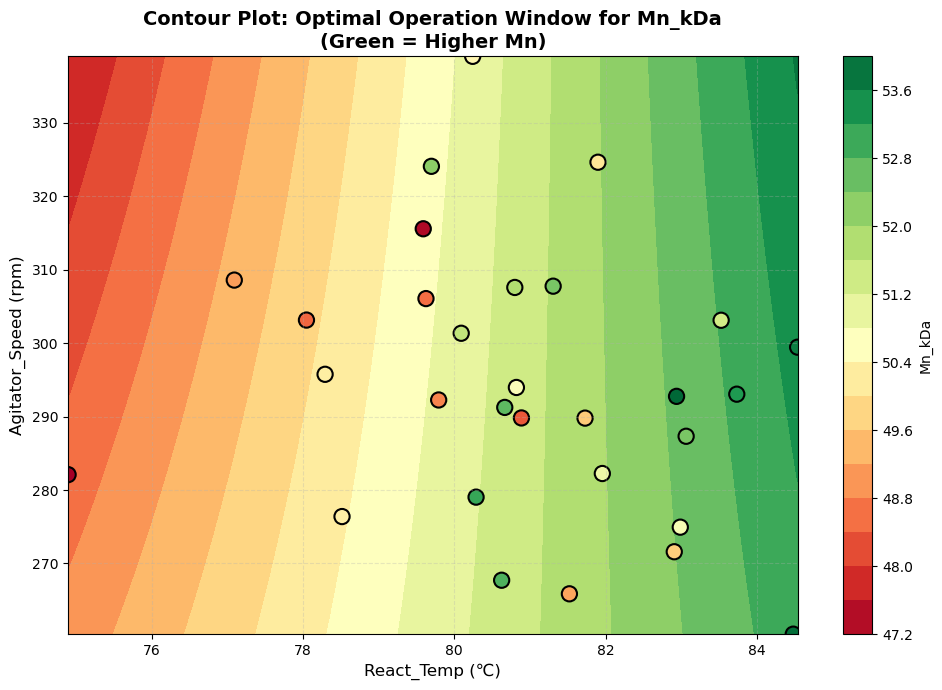


🎯 預測最佳操作條件：
  溫度: 84.5 ℃
  攪拌速度: 339 rpm
  預測 Mn: 53.64 kDa


In [7]:
# 3. 等高線圖：尋找最佳操作窗口

plt.figure(figsize=(10, 7))
contour = plt.contourf(T_grid, A_grid, Mn_grid, levels=15, cmap='RdYlGn')
plt.colorbar(contour, label='Mn_kDa')
plt.scatter(df_batch['React_Temp'], df_batch['Agitator_Speed'], 
            c=df_batch['Mn_kDa'], s=120, edgecolors='black', cmap='RdYlGn', linewidths=1.5)
plt.xlabel('React_Temp (℃)', fontsize=12)
plt.ylabel('Agitator_Speed (rpm)', fontsize=12)
plt.title('Contour Plot: Optimal Operation Window for Mn_kDa\n(Green = Higher Mn)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '13_batch_contour.png', dpi=150, bbox_inches='tight')
plt.show()

# 找出最佳操作條件
max_idx = Mn_grid.argmax()
optimal_T = T_grid.flat[max_idx]
optimal_A = A_grid.flat[max_idx]
optimal_Mn = Mn_grid.flat[max_idx]
print(f"\n🎯 預測最佳操作條件：")
print(f"  溫度: {optimal_T:.1f} ℃")
print(f"  攪拌速度: {optimal_A:.0f} rpm")
print(f"  預測 Mn: {optimal_Mn:.2f} kDa")

<Figure size 1000x600 with 0 Axes>

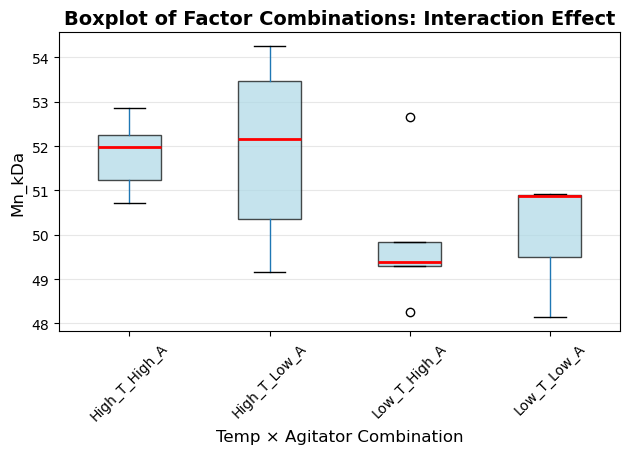


組合統計摘要：
                    mean       std        min        max
Combination                                             
High_T_High_A  51.811089  0.799941  50.720792  52.855270
High_T_Low_A   52.001207  1.770906  49.151667  54.261510
Low_T_High_A   49.885432  1.657599  48.261140  52.668025
Low_T_Low_A    49.975264  1.594657  48.133980  50.909512


In [8]:
# 4. 因子組合箱型圖：離散化檢視交互作用
df_batch['Temp_Bin'] = pd.cut(df_batch['React_Temp'], bins=2, labels=['Low_T', 'High_T'])
df_batch['Agit_Bin'] = pd.cut(df_batch['Agitator_Speed'], bins=2, labels=['Low_A', 'High_A'])
df_batch['Combination'] = df_batch['Temp_Bin'].astype(str) + '_' + df_batch['Agit_Bin'].astype(str)

# Boxplot
plt.figure(figsize=(10, 6))
df_batch.boxplot(column='Mn_kDa', by='Combination', grid=False, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2))
plt.suptitle('')  # Remove default title
plt.xlabel('Temp × Agitator Combination', fontsize=12)
plt.ylabel('Mn_kDa', fontsize=12)
plt.title('Boxplot of Factor Combinations: Interaction Effect', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '14_batch_combination_box.png', dpi=150, bbox_inches='tight')
plt.show()

# 統計摘要
print("\n組合統計摘要：")
print(df_batch.groupby('Combination')['Mn_kDa'].describe()[['mean', 'std', 'min', 'max']])